The aim of this notebook is to perform a quick test for an update of the model or a new optimization procedure.
To test a model update, each cell of this notebook must run with correct results.
To test a new optimization procedure, a new dedicated cell must be created on the same model as the previous ones.

As this pipeline consist in only one instance solved by each procedure once, it statisticaly has no meaning. For a statisticaly meaningful test pipeline, please run the Test pipeline notebook (heavily time consuming). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image

Error: IPOPT shared library failed to import


Generate the theoritical organoïd

In [2]:
organo = generate_ring(12,110,150)
Nf= len(organo.face_df.area)
geom.update_all(organo)

# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  1.1*organo.face_df.area, 
        'area_elasticity': 1,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 1.0,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 100.,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)


organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 10.0

new_tensions = np.concatenate((organo.edge_df.loc[:Nf-1,'line_tension']*4.0*np.random.normal(1.0,0.2,organo.Nf),
                               organo.edge_df.loc[Nf:2*Nf-1,'line_tension']*2.0*np.random.normal(1.0,0.2,organo.Nf),
                               organo.edge_df.loc[2*Nf:3*Nf-1,'line_tension']*np.random.normal(1.0,0.2,organo.Nf)))

organo.edge_df.loc[:,'line_tension'] = prepare_tensions(organo, new_tensions)
                                                          
res = Solver.find_energy_min(organo, geom, model)                                                       

Reseting datasets values with new specs


Creating a printing function

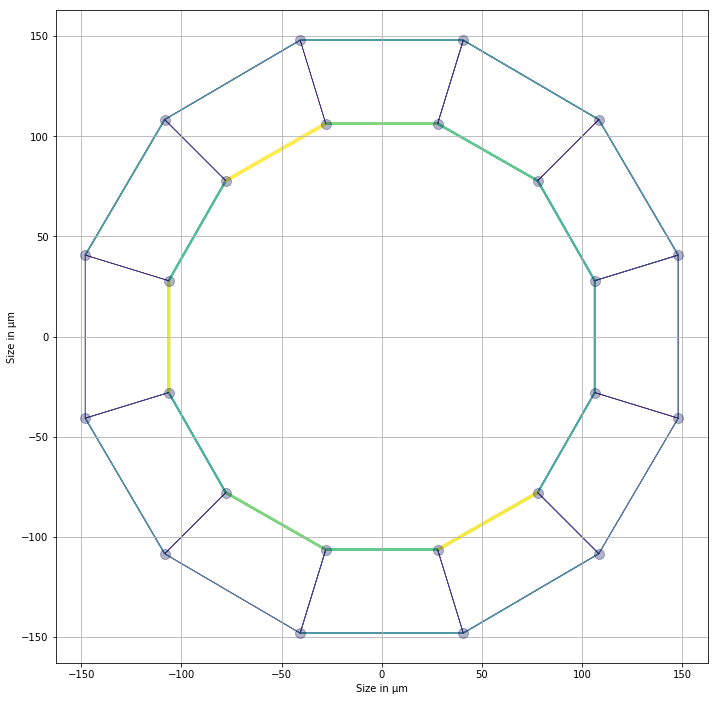

In [11]:
def print_tensions(orga):
    draw_specs = sheet_spec()

    edge_color = np.array([1/max(orga.edge_df.line_tension)*l for l in orga.edge_df.line_tension])

    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['edge']['color'] = edge_cmap #[0, 0, 0, 1]
    #draw_specs['edge']['color'] = [0, 0, 0, 0.2]

    draw_specs['edge']['width'] = 0.25+3*np.array([1/max(orga.edge_df.line_tension)*l for l in orga.edge_df.line_tension])
    fig, ax = sheet_view(orga, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')
    plt.show()
    pass

print_tensions(organo)

Define the optimization parameters

In [4]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}

trf_opt = {'bounds': ([0]*(3*organo.Nf),[100]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-1, 'verbose': 0}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-1, 'verbose': 0}
psqp_opt = {'lb': 0, 'ub': 100, 'method': 'PSQP'}

In [6]:
theta = 0.04

# Robustness to extraction errors

At first we test robustness to extraction errors. This is done by create an organoïd whit perturbated (x,y) coordinates. 
Then we run the optimization procedure, which gives us an experimental organoïd, and measure how far the result is from the theoritical organoïd.

## LM distance minimization
This minimization procedure uses Levenberg-Marquardt (lm) procedure from scipy.least_squares to find the set of linear tensions that minimize the euclidian distance from the theoritical organoid to the experimental organoid. 
It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.
A particularity of lm algorithm is that it needs at least as many residuals as optimization parameters. 
Also, it does not support bounds. 

As residuals, we will consider the vertex to vertex distance from the experimental organoïd to the theoritical organoïd (2/3 Nf residuals) , the regularization module edge to edge value if needed (2/3 Nf residuals), and bound penalties of the form  $$ M*(min(0,l)+min(0,UB-l)) \forall l \in L$$ Where $M$ is a big negative number, $UB_l$ is the upper bound for parameter $l$, $L$ is the set of optimization parameters.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [7]:
start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **lm_opt)
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x)
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x))))
print_tensions(noisy)

TypeError: must be str, not float

Solving time: 725.257645
Tension error: 169.6325578782836


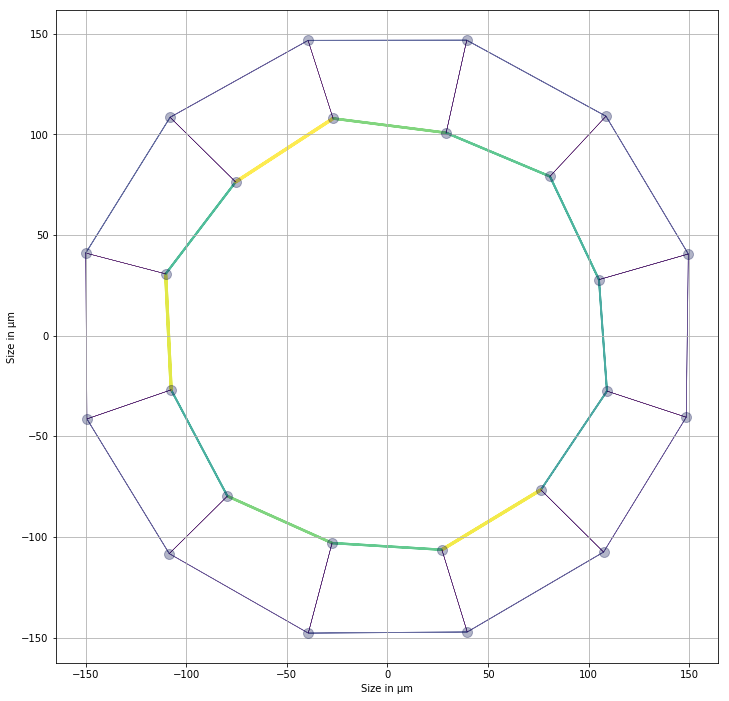

In [12]:
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x))))
print_tensions(noisy)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

Solving time: 727.7855820000001
Tension error: 170.64762836947307


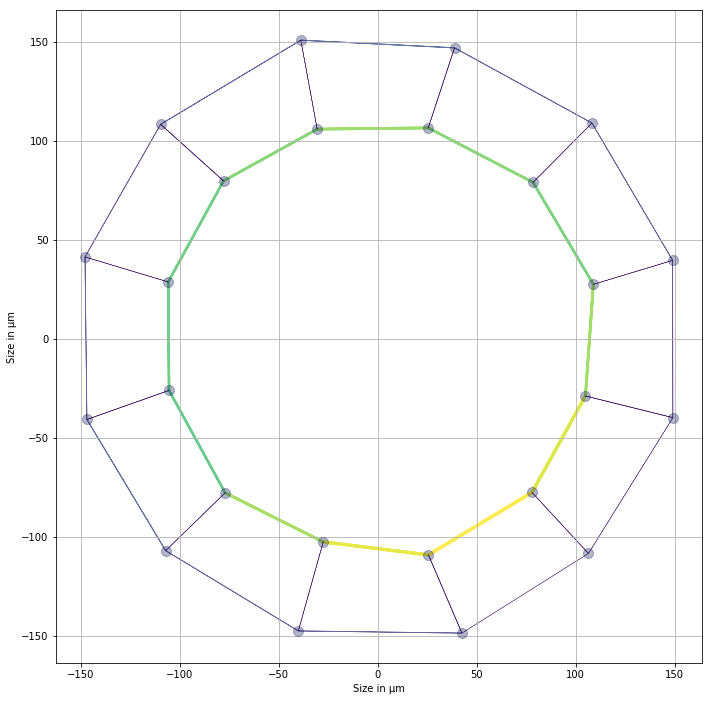

In [14]:
reg_weight = 1.0

start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **lm_opt)
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x)
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x))))
print_tensions(noisy)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

Solving time: 462.3953200000001
Tension error: 169.63236557115124


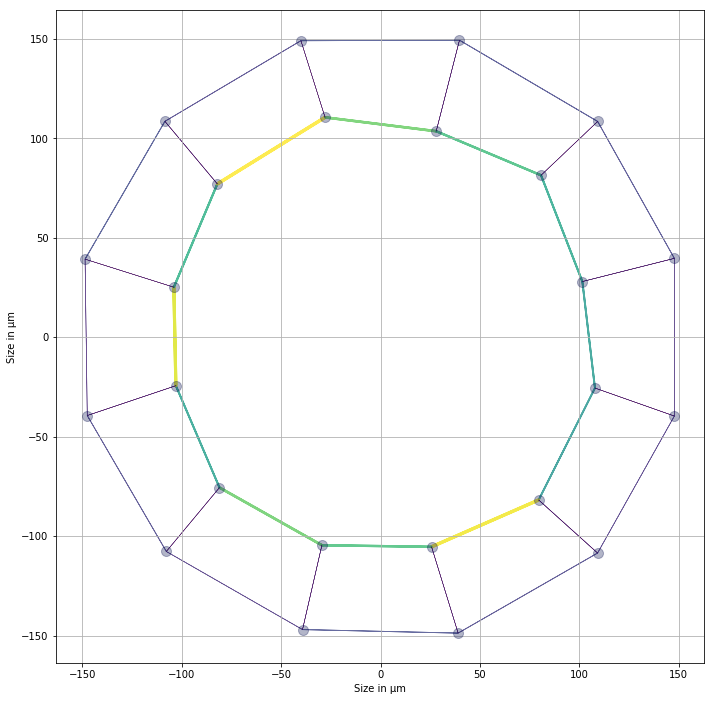

In [17]:
start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf],
                                [organo.settings['lumen_volume']]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **lm_opt)
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x[:3*organo.Nf]))))
print_tensions(noisy)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

Solving time: 956.6376599999999
Tension error: 169.2844262542265


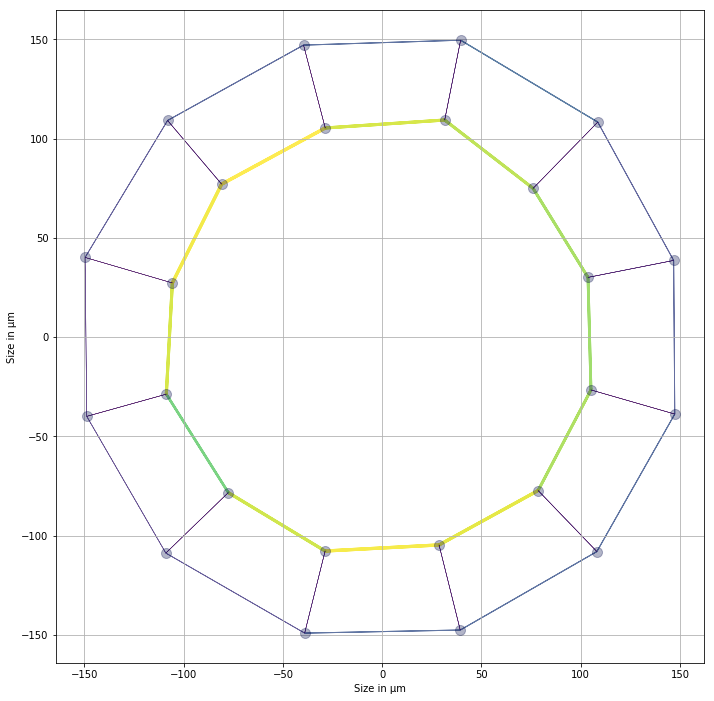

In [18]:
reg_weight = 1.0

start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf],
                                [organo.settings['lumen_volume']]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess,
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **lm_opt)
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x[:3*organo.Nf]))))
print_tensions(noisy)

## TRF distance minimization
This minimization procedure uses Trust Region Function (trf) procedure from scipy.least_squares to find the set of linear tensions that minimize the euclidian distance from the theoritical organoid to the experimental organoid. 
It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

Solving time: 219.24020400000018
Tension error: 169.63236557115124


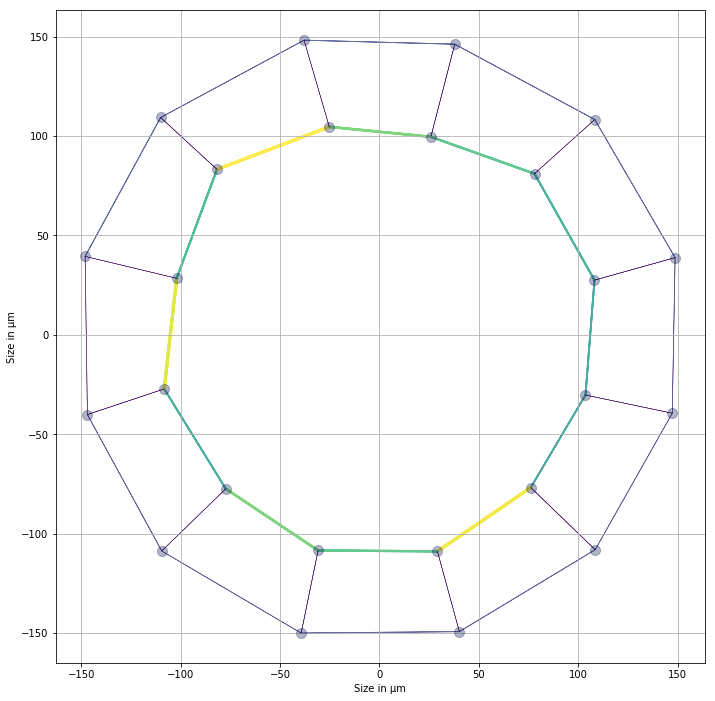

In [19]:
start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **trf_opt) 
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x)
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x))))
print_tensions(noisy)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

Solving time: 479.66230799999994
Tension error: 170.29897829942195


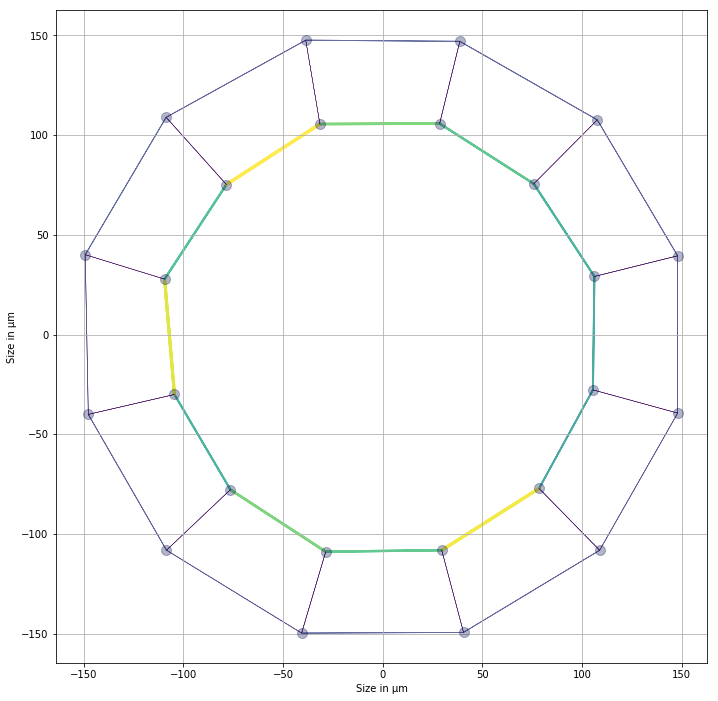

In [20]:
reg_weight = 1.0

start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **trf_opt)
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x)
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x))))
print_tensions(noisy)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

Solving time: 155.4983830000001
Tension error: 169.63236557115124


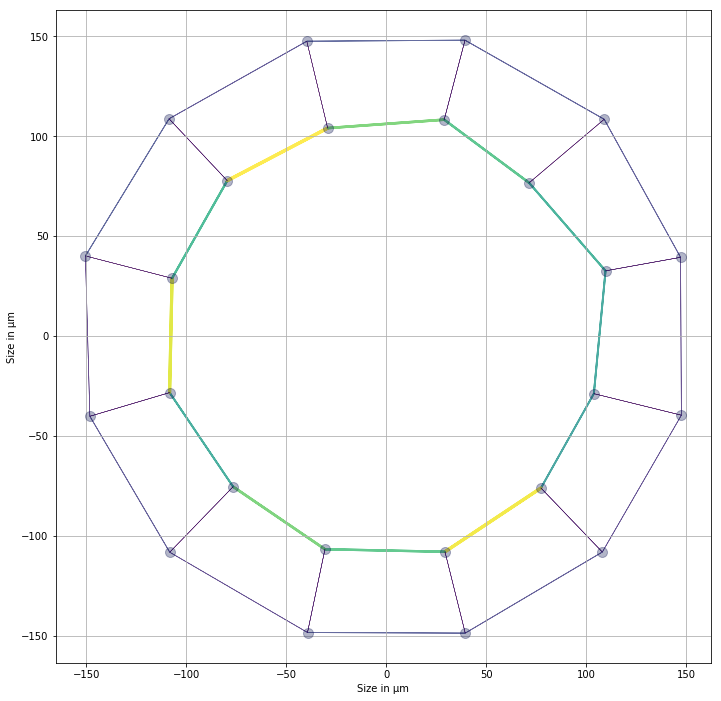

In [22]:
trf_opt = {'bounds': ([0]*(3*organo.Nf+1),[100]*(3*organo.Nf)+[1e6]), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-1, 'verbose': 0}
start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf],
                                [organo.settings['lumen_volume']]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **trf_opt)
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x[:3*organo.Nf]))))
print_tensions(noisy)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

Solving time: 426.55234199999995
Tension error: 169.63218601623853


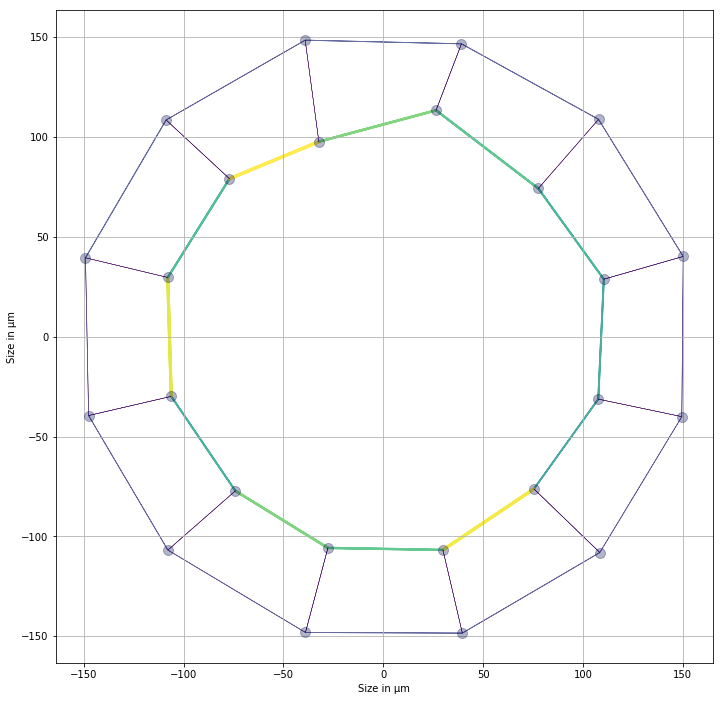

In [23]:
reg_weight = 1.0
trf_opt = {'bounds': ([0]*(3*organo.Nf+1),[100]*(3*organo.Nf)+[1e6]), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-1, 'verbose': 0}
start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf],
                                [organo.settings['lumen_volume']]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess,
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **trf_opt) 
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x[:3*organo.Nf]))))
print_tensions(noisy)

TRF always give the same results :

In [26]:
res.x

array([1.14818396e+01, 2.22522667e+01, 1.55624560e+01, 1.71933051e+01,
       1.24484629e+01, 2.14585344e+01, 1.40282017e+01, 2.27110115e+01,
       1.72360681e+01, 1.52775080e+01, 1.31709041e+01, 1.21399372e+01,
       3.15872111e+00, 4.00895917e+00, 4.77641948e+00, 3.04769090e+00,
       4.05715035e+00, 2.46009800e+00, 4.89826289e+00, 3.84652540e+00,
       5.00936779e+00, 4.46384821e+00, 4.28120423e+00, 2.81508156e+00,
       9.40882132e-01, 1.16908035e+00, 8.16872158e-01, 1.00063139e+00,
       7.56142485e-01, 9.51799154e-01, 5.79910101e-01, 1.00424214e+00,
       6.74672597e-01, 1.11704438e+00, 6.82579780e-01, 1.11432614e+00,
       7.26014670e+04])

In [28]:
model.compute_energy(organo,True)

[face
 0     0.104860
 1     0.114886
 2     0.137184
 3     0.111217
 4     0.103957
 5     0.144754
 6     0.102748
 7     0.111709
 8     0.138228
 9     0.109097
 10    0.108897
 11    0.141656
 dtype: float64, edge
 0      82.509889
 1     159.903811
 2     108.637260
 3     123.551146
 4      89.451543
 5     149.798374
 6     100.806832
 7     163.200437
 8     120.323586
 9     109.784254
 10     94.646430
 11     84.745486
 12     61.917345
 13     78.586737
 14     97.236182
 15     59.745132
 16     79.531095
 17     50.083936
 18     96.019306
 19     75.403040
 20    101.981703
 21     87.503151
 22     83.922214
 23     57.308420
 24     20.501840
 25     25.229741
 26     17.800114
 27     21.803483
 28     16.317510
 29     20.739605
 30     12.635062
 31     21.672641
 32     14.700521
 33     24.339297
 34     14.731993
 35     24.280723
 36     24.048035
 37     20.501985
 38     25.473893
 39     17.629379
 40     21.803553
 41     16.475532
 42     20.540724
 43   

In [30]:
np.mean(organo.face_df.area-organo.face_df.prefered_area)

-0.4870509193629384

In [31]:
np.mean(organo.face_df.area/organo.face_df.prefered_area)

0.9998297024757473

## PSQP energy minimization
This minimization procedure uses Preconditionned Sequential Quadratic Programming (PSQP) procedure from pyOpt to find the set of linear tensions that minimizes the energy in the experimental organoïd under constraint that 
$$||X_e-X_t||<\epsilon $$
Where $X_e$ (resp. $X_t$) is the set of euclidian coordinates of the vertices of the experimental (resp. theoritical) organoïd, and $\epsilon$ is the maximum distance allowed between the two. 
Initial point is computed with lm procedure.

It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, lm_opt, **psqp_opt)
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x)
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x))))
print_tensions(noisy)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
reg_weight = 1.0

start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, lm_opt, **psqp_opt)
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x)
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x))))
print_tensions(noisy)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf],
                                [organo.settings['lumen_volume']]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, lm_opt, **psqp_opt)
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x[:3*organo.Nf]))))
print_tensions(noisy)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
noisy = organo.copy()
initial_guess = np.concatenate((organo.edge_df.line_tension[:Nf]*4,
                                organo.edge_df.line_tension[Nf:2*Nf]*2,
                                organo.edge_df.line_tension[2*Nf:3*Nf],
                                [organo.settings['lumen_volume']]))
noisy.vert_df.loc[:,('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
res = adjust_tensions(noisy, initial_guess,
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, lm_opt, **psqp_opt) 
noisy.edge_df.line_tension = prepare_tensions(noisy,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.sum(np.abs(organo.edge_df.line_tension[:3*organo.Nf]-res.x[:3*organo.Nf]))))
print_tensions(noisy)